**Aerial Image Semantic Segmentation**

_Simone Vaccari_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from PIL import Image
import cv2
from tqdm import tqdm
import seaborn as sns
import time
from scipy.stats import mode


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Keras/Tensorflow

import tensorflow as tf
from tensorflow import keras

try:
  import tensorflow_addons as tfa
except ModuleNotFoundError:
  !pip install tensorflow-addons
  import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Activation, Reshape, BatchNormalization, add
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.models import Model

try:
  import keras_tuner as kt
except:
  !pip install keras-tuner
  import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGE PATH TO YOUR DIRECTORY
%cd '/content/drive/MyDrive/DroneDataset'

Mounted at /content/drive
/content/drive/MyDrive/EnvironmentExam/DroneDataset


## Support Functions

In [3]:
'''
Plot the class names with the corresponding color
'''
def visualize_classes_colors(classes):
  colors = []
  for index,c_class in enumerate(classes.name):
    plt.subplot(6,4,index+1)
    (r,g,b)=classes.iloc[index].values[1:]
    color = np.array([[[r,g,b],[r,g,b],[r,g,b]]])
    colors.append(color)
    plt.title(c_class)
    plt.imshow(color)
    plt.axis('off')
  return colors


'''
Plot original images and corresponding labels from paths
'''
def plot_img_label(img_paths, label_paths, n=3):
  for i in range(n):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    image = plt.imread(img_paths[i])
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    label = plt.imread(label_paths[i])
    ax2.imshow(label, cmap="gray")
    ax2.set_title("Semantic Label")
    ax2.axis('off')
    plt.show()


'''
Load a mask from its path
'''
def load_label(label_path):
  label = tf.io.read_file(label_path)
  label = tf.image.decode_png(label, channels=3)
  label = tf.math.reduce_max(label,axis=-1,keepdims=True)
  return label


'''
Count how many pixels for each class there are in the provided masks
'''
def count_pixels_per_class(labels_paths):
  # Initialize an array to save the pixel counts for each class
  class_counts = np.zeros(NUM_CLASSES, dtype=np.int64)

  # Iterate through all labels and count the pixels for each class
  for label_path in tqdm(labels_paths):
    label = load_label(label_path)
    label_np = label.numpy().squeeze()
    unique, counts = np.unique(label_np, return_counts=True)
    for cls, count in zip(unique, counts):
      class_counts[cls] += count

  return class_counts


'''
Plots the class distribution of pixels in the specified dataset
'''
def plot_class_pixel_counts(class_counts, ds="All"):
  plt.figure(figsize=(10, 6))
  plt.bar(range(NUM_CLASSES), class_counts, color=[color[0,0,:] for color in NORMALIZED_COLORS])
  plt.xlabel('Class')
  plt.ylabel('Number of Pixels')
  plt.title(f'Class Distribution of Pixels in {ds} Masks')
  plt.xticks(range(NUM_CLASSES), CLASSES_NAMES, rotation=45)
  plt.show()

## Load the data and Dataset Exploration

In [4]:
# Load images, segmented images (labels), and class mapping
original_images = sorted(glob.glob('original_images/*.jpg'))
grayscale_labels = sorted(glob.glob('label_images_semantic/*.png'))

classes = pd.read_csv('class_dict_seg.csv')


In [ ]:
# Visualize first elements of classes df
classes.head(3)

name    r   g    b
0   unlabeled    0   0    0
1  paved-area  128  64  128
2        dirt  130  76    0

In [5]:
# Define classes variables
NUM_CLASSES = len(classes)
CLASSES_NAMES = classes.name.values

In [ ]:
# Check how many classes we have and classes names
print(f"There are {NUM_CLASSES} classes in the dataset:")
print(classes.name)

There are 24 classes in the dataset:
0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object


(24, 3)

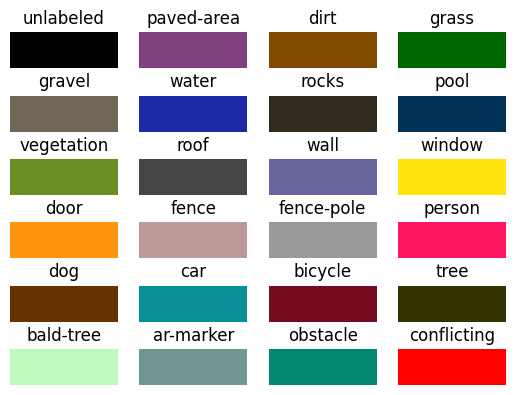

In [6]:
# Define colors for visualization
COLORS = visualize_classes_colors(classes)
NORMALIZED_COLORS = [color / 255 for color in COLORS]
CMAP = np.array(list(classes[[' r', ' g', ' b']].transpose().to_dict('list').values()))
CMAP.shape

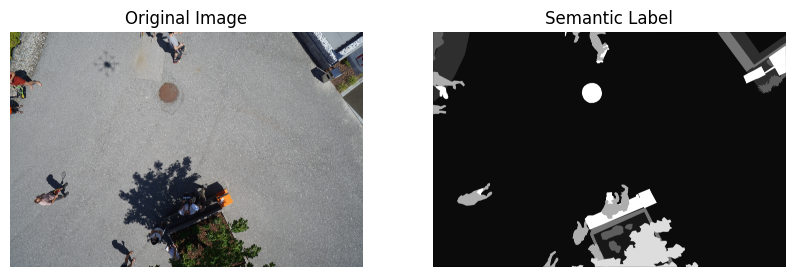

In [ ]:
# Plot an image and the corresponding label
plot_img_label(original_images, grayscale_labels, n=1)

In [ ]:
# Check image shape
img = cv2.imread(original_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

(4000, 6000, 3)


In [ ]:
# This was run just once to make sure all images have the same shape
"""
for path in original_images:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if img.shape != (4000, 6000, 3):
    print(f"{path} has size {img.size}")
"""

In [ ]:
# Check label shape
label = cv2.imread(grayscale_labels[0])
print(label.shape)
print(label.dtype)
print(label)

(4000, 6000, 3)
uint8
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [ ]:
print(label.min(), label.max())

0 22


Even though the image has 3 channels, it has always the same value along the last dimension, which is a number between 0 and 23, representing the class of that pixel. Thus, when loading the images, it is sufficient to "consider" only 1 channel (grayscale images).

In [7]:
# Compute the classes counts in the whole dataset
try:
  class_counts_all = np.load("/content/drive/MyDrive/class_counts.npy")
except:
  class_counts_all = count_pixels_per_class(grayscale_labels)
  # np.save("/content/drive/MyDrive/class_counts_all.npy", class_counts_all)

In [8]:
# Print them with the class indices
pd.Series(class_counts_all)

0       20891755
1     3622913197
2      307253346
3     1918375679
4      701671000
5      212497466
6       68981845
7       61394148
8      681674538
9      706871405
10     258344612
11      53700119
12       3010773
13      91957901
14       5100883
15     101021522
16       1365585
17      75513357
18      20702183
19     196940774
20     127775057
21      21849983
22     340192872
23             0
dtype: int64

Since the last class never appears, we remove it.

In [9]:
# IMPORTANT: RUN THIS
NUM_CLASSES -= 1
CLASSES_NAMES = CLASSES_NAMES[:-1]
NORMALIZED_COLORS.pop(-1)
CMAP = CMAP[:-1]
CMAP.shape

(23, 3)

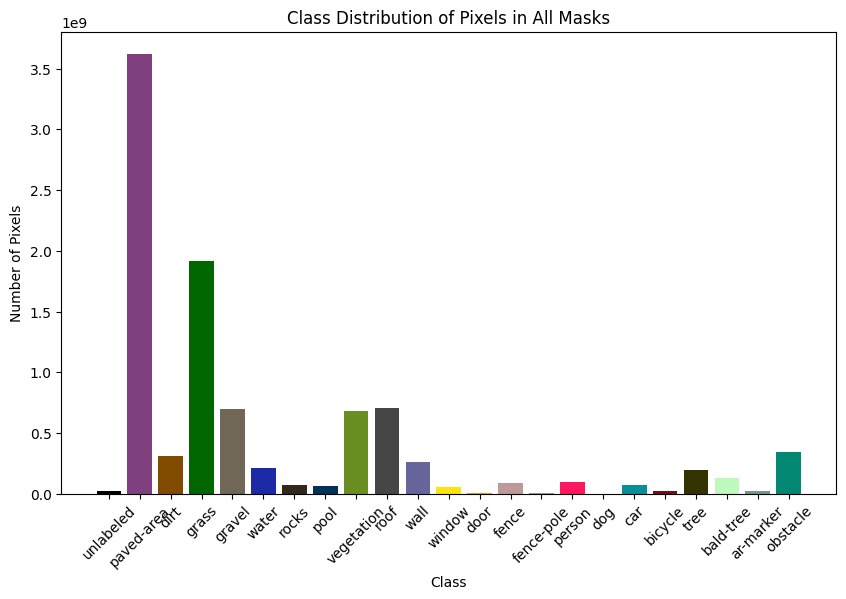

In [10]:
# Plot class counts in the whole dataset
plot_class_pixel_counts(class_counts_all[:-1], ds="All")

The dataset seems to be quite unbalanced, with a high prevalence of pixels representing paved-areas or grass.

## Data Split and Dataset Creation

In [ ]:
# Split the data into training, validation, and testing
rs = 42

# First, split into 80% train and 20% (validation + test)
image_train_paths, image_temp_paths, label_train_paths, label_temp_paths = train_test_split(original_images, grayscale_labels, test_size=0.2, random_state=rs)

# Then, split the 20% into half (10% validation and 10% test)
image_valid_paths, image_test_paths, label_valid_paths, label_test_paths = train_test_split(image_temp_paths, label_temp_paths, test_size=0.5, random_state=rs)

print(len(image_train_paths), " training images")
print(len(image_valid_paths), " validation images")
print(len(image_test_paths), " testing images")


320  training images
40  validation images
40  testing images


In [ ]:
# Resized dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 192

In [ ]:
# Define augmentation functions
def horizontal_flip(image, label):
  image = tf.image.flip_left_right(image)
  label = tf.image.flip_left_right(label)
  return image, label


def vertical_flip(image, label):
  image = tf.image.flip_up_down(image)
  label = tf.image.flip_up_down(label)
  return image, label


def random_rotation(image, label):
  angle = tf.random.uniform((), minval=-np.pi/4, maxval=np.pi/4)
  image = tfa.image.rotate(image, angle)
  label = tfa.image.rotate(label, angle)
  return image, label


def brightness_adjustment(image, label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  return image, label


def contrast_adjustment(image, label):
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  return image, label


def random_saturation(image, label):
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
  return image, label

# List of augmentation functions
AUGMENTATIONS = [horizontal_flip, vertical_flip, random_rotation] # brightness_adjustment, contrast_adjustment, random_saturation


# Function to apply all augmentations to an image
def apply_augmentations(image, label):
  augmented_images = []
  augmented_labels = []
  for aug_func in AUGMENTATIONS:
    aug_img, aug_label = aug_func(image, label)
    augmented_images.append(aug_img)
    augmented_labels.append(aug_label)

  return augmented_images, augmented_labels


# Load and augment training images
def load_image_train(image_path, label_path):

  # Read image as tensor and pre-process
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH), method="nearest")  # resize
  img = tf.image.convert_image_dtype(img, tf.float32)       # normalize

  # Read mask as tensor and pre-process
  label = tf.io.read_file(label_path)
  label = tf.image.decode_png(label, channels=3)
  label = tf.math.reduce_max(label, axis=-1, keepdims=True)     # keeps only the max value along the last axis, reducing the shape to (WIDTH, HEIGHT, 1)
  label = tf.image.resize(label, (IMG_HEIGHT, IMG_WIDTH), method="nearest")
  label = tf.cast(label, tf.uint8)

  # Apply augmentations
  augmented_images, augmented_labels = apply_augmentations(img, label)

  # Add original image
  augmented_images = [img] + augmented_images
  augmented_labels = [label] + augmented_labels

  return augmented_images, augmented_labels


def load_image_test(image_path, label_path):

  # Read image as tensor and pre-process
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH), method="nearest")  # resize
  img = tf.image.convert_image_dtype(img, tf.float32)   # normalize img

  # Read mask as tensor and pre-process
  label = tf.io.read_file(label_path)
  label = tf.image.decode_png(label, channels=3)
  label = tf.math.reduce_max(label,axis=-1,keepdims=True)
  label = tf.image.resize(label, (IMG_HEIGHT, IMG_WIDTH), method="nearest")  # resize label
  label = tf.cast(label, tf.uint8)

  return img, label

In [ ]:
# Define Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((image_train_paths, label_train_paths))
train_dataset = train_dataset.flat_map(lambda image, label: tf.data.Dataset.from_tensor_slices(load_image_train(image, label)))

valid_dataset = tf.data.Dataset.from_tensor_slices((image_valid_paths, label_valid_paths))
valid_dataset = valid_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((image_test_paths, label_test_paths))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Create batches of data
BATCH_SIZE = 16
BUFFER_SIZE = 100

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_batches = valid_dataset.cache().batch(BATCH_SIZE)
test_batches = test_dataset.cache().batch(BATCH_SIZE)


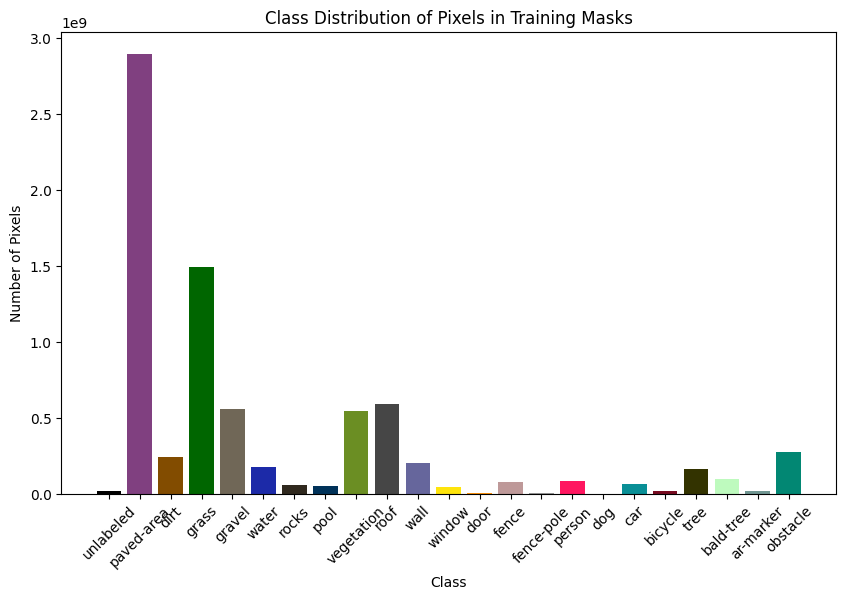

In [ ]:
# Classes distibution in training masks
try:
  class_counts_tr = np.load("/content/drive/MyDrive/class_counts_tr.npy")
except:
  class_counts_tr = count_pixels_per_class(label_train_paths)
  # np.save("/content/drive/MyDrive/class_counts_tr.npy", class_counts_tr)

plot_class_pixel_counts(class_counts_tr, ds="Training")

In [ ]:
# Print values with class indices
pd.Series(class_counts_tr)

0       16359840
1     2894550913
2      242547539
3     1489111430
4      559132963
5      178882843
6       58702994
7       53203085
8      546642059
9      592963298
10     205058729
11      44208981
12       2272177
13      76524827
14       3981527
15      81908912
16       1074438
17      63332672
18      15227344
19     162261296
20      99826217
21      18731500
22     273494416
23             0
dtype: int64

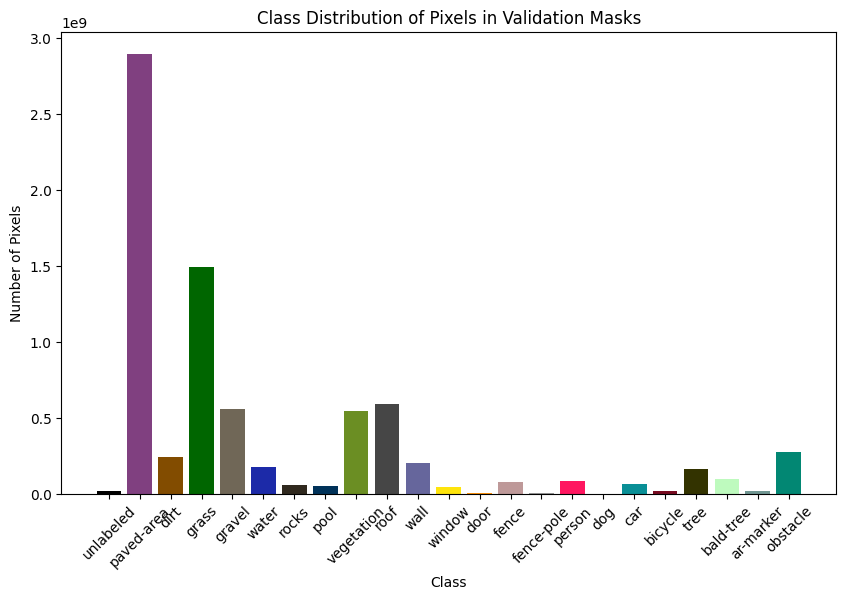

In [ ]:
# Classes distibution in validation masks
try:
  class_counts_val = np.load("/content/drive/MyDrive/class_counts_val.npy")
except:
  class_counts_val = count_pixels_per_class(label_valid_paths)
  # np.save("/content/drive/MyDrive/class_counts_val.npy", class_counts_tr)

plot_class_pixel_counts(class_counts_val, ds="Validation")

In [ ]:
# Print values with class indices
pd.Series(class_counts_val)

0       16359840
1     2894550913
2      242547539
3     1489111430
4      559132963
5      178882843
6       58702994
7       53203085
8      546642059
9      592963298
10     205058729
11      44208981
12       2272177
13      76524827
14       3981527
15      81908912
16       1074438
17      63332672
18      15227344
19     162261296
20      99826217
21      18731500
22     273494416
23             0
dtype: int64

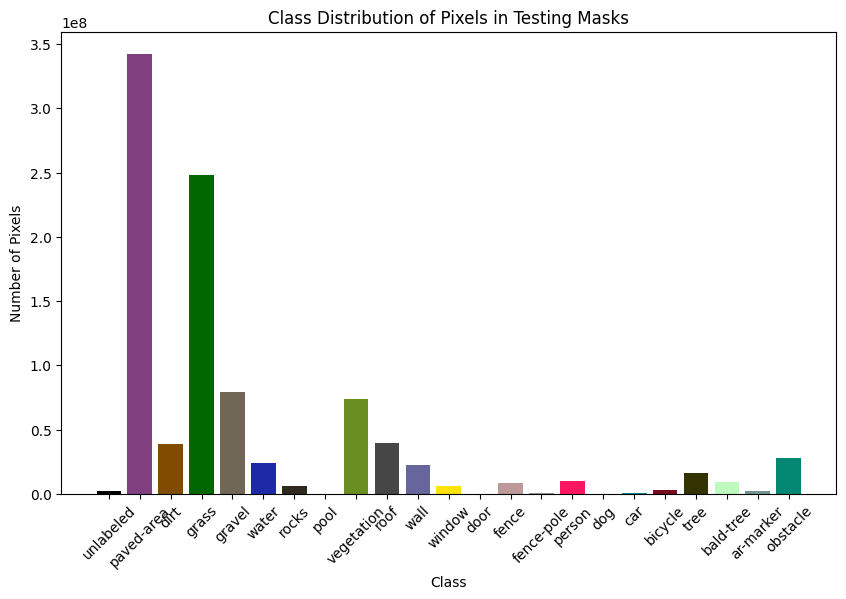

In [12]:
# Classes distibution in testing masks
try:
  class_counts_test = np.load("/content/drive/MyDrive/class_counts_test.npy")
except:
  class_counts_test = count_pixels_per_class(label_test_paths)
  # np.save("/content/drive/MyDrive/class_counts_test.npy", class_counts_test)

plot_class_pixel_counts(class_counts_test, ds="Testing")

In [13]:
# Print values with class indices
pd.Series(class_counts_test)

0       2197057
1     342433579
2      38990802
3     247783795
4      79503768
5      23687635
6       5735241
7             0
8      74071603
9      39655115
10     22415231
11      6344825
12       184562
13      8578420
14       597615
15      9871179
16            0
17       686850
18      2756111
19     16100100
20      8792132
21      1859284
22     27755096
dtype: int64

We observe that 2 classes ('pool' and 'dog') are not present in the test dataset. However, since we're simulating obtaining new unseen data samples and this is quite a plausible scenario, we decide to leave the split unchanged, and see how the model behaves.

### Data Visualization

In [ ]:
'''
Plots original image with gt and predicted mask
'''
def display(display_list, pos=None):
  plt.figure(figsize=(10, 6))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])

    if i == 0:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    else:
      plt.imshow(colorize_mask(display_list[i]))
      if pos and i==2:
        plt.plot(pos[1], pos[0], 'xr', markersize=8, markeredgewidth=3)
        plt.title("Landing Position")

    plt.axis("off")
  plt.show()


'''
Map the grayscale mask to the right colors
'''
def colorize_mask(mask):
  mask = tf.squeeze(mask).numpy()
  rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

  for i in range(NUM_CLASSES):
    rgb_mask[mask == i] = CMAP[i]

  return rgb_mask


'''
Plots augmented images
'''
def visualize_augmentations(image_path, label_path, augm=["Horizontal Flip", "Vertical Flip", "Random Rotation"]):
  # Load the original image and label, and their augmentations
  augmented_images, augmented_labels = load_image_train(image_path, label_path)

  augmented_images_np = [img.numpy() for img in augmented_images]
  augmented_labels_np = [label.numpy().squeeze() for label in augmented_labels]

  # Plot the original image and its augmentations
  fig, axes = plt.subplots(2, len(augmented_images_np), figsize=(15, 6))
  axes[0, 0].imshow(augmented_images_np[0])
  axes[0, 0].set_title('Original Image')
  axes[0, 0].axis('off')

  axes[1, 0].imshow(colorize_mask(augmented_labels_np[0]))
  axes[1, 0].axis('off')

  for i in range(1, len(augmented_images_np)):
    axes[0, i].imshow(augmented_images_np[i])
    axes[0, i].set_title(augm[i - 1])
    axes[0, i].axis('off')

    axes[1, i].imshow(colorize_mask(augmented_labels_np[i]))
    axes[1, i].axis('off')

  plt.tight_layout()
  plt.show()


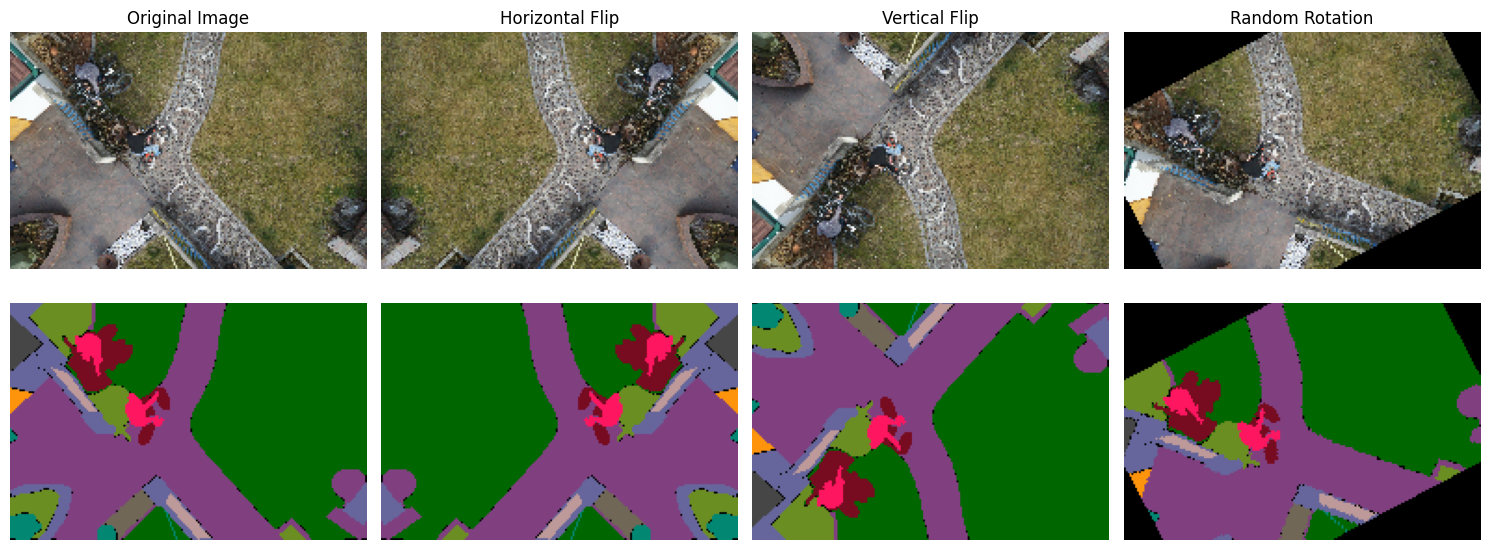

In [ ]:
# Plot a sample of augmented images
visualize_augmentations(image_train_paths[0], label_train_paths[0])

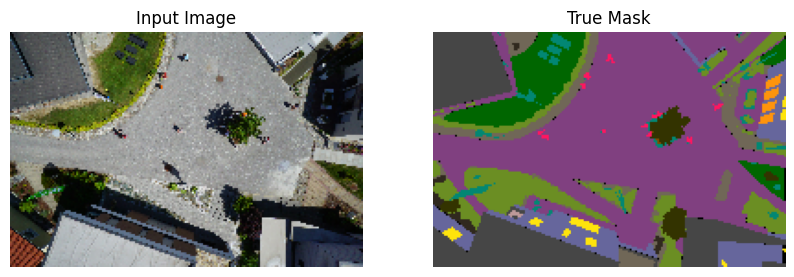

In [ ]:
# Plot a sample of input image and corresponding mask
sample_batch = next(iter(train_batches))    # tuple of 2 tensors (imgs,masks) both of shape [BATCH_SIZE, 128, 192, 3]
random_index = np.random.choice(sample_batch[0].shape[0])   # choose a random number in [0, BATCH_SIZE]
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Model Definition

### U-Net
  Paper: https://arxiv.org/abs/1505.04597

In [ ]:
'''
Convolutional downsampling block
'''
def downsampling_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):

  # Two convolutional layers
  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(inputs)
  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  # Dropout layer if specified
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  # Max pooling layer if specified
  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2,2))(conv)

  else:
    next_layer = conv

  # Skip connection
  skip_connection = conv

  return next_layer, skip_connection

In [ ]:
'''
Convolutional upsampling block
'''
def upsampling_block(prev_input, skip_input, n_filters=64, dropout_prob=0):

  # Upsample layer
  up = Conv2DTranspose(
                n_filters,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(prev_input)

  # Merge the previous output and the skip_input
  merge = concatenate([up, skip_input], axis=3)     # to implement skip connections

  if dropout_prob > 0:
    # Dropout layer
    merge = Dropout(dropout_prob)(merge)

  # Two convolutional layers
  conv = Conv2D(n_filters,
                kernel_size=(3,3),
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(n_filters,
                kernel_size=(3,3),
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv


Run one of the 2 following sections:
- Hyperparameter Tuning: to find the optimal hyperparamters for this model
- Build Model: to build the model for training

#### Hyperparameter Tuning

In [ ]:
def mean_iou_training(y_true, y_pred):
  # Flatten the ground truth and prediction tensors
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.argmax(y_pred, axis=-1)
  y_pred = tf.reshape(y_pred, [-1])

  # Update the internal state of the metric
  mean_iou_tr.update_state(y_true, y_pred)

  # Return the current mean IoU
  return mean_iou_tr.result()


mean_iou_tr = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)


def build_unet(hp, input_size=(IMG_HEIGHT, IMG_WIDTH, 3), n_filters=64, n_classes=NUM_CLASSES):

  inputs = Input(input_size)
  # Contracting Path (encoding). Pass the first element of the output of each block as the input of the next block
  # and double the number of filters at each new step

  # Hyperparameters to optimize
  n_filters = hp.Choice("num_initial_filters", values=[64, 32, 16])
  drop_prob = hp.Choice("dropout_probability", values=[0.1, 0.2, 0.3])

  # 1st downsampling block
  dblock1 = downsampling_block(inputs, n_filters)
  # 2nd downsampling block
  dblock2 = downsampling_block(dblock1[0], n_filters*2)
  # 3rd downsampling block
  dblock3 = downsampling_block(dblock2[0], n_filters*4)
  # 4th downsampling block (with dropout)
  dblock4 = downsampling_block(dblock3[0], n_filters*8, dropout_prob=drop_prob)

  # 5th downsampling block with dropout and no max pooling --> bottleneck
  dblock5 = downsampling_block(dblock4[0], n_filters*16, dropout_prob=drop_prob, max_pooling=False)

  # Expanding Path (decoding). We pass the output of the bottleneck as the previous input and the skip connection from dblock4.
  # At each step, we use half the number of filters of the previous step

  # 1st upsampling block.
  ublock6 = upsampling_block(dblock5[0], dblock4[1],  n_filters*8, dropout_prob=drop_prob)
  # 2nd upsampling block
  ublock7 = upsampling_block(ublock6, dblock3[1],  n_filters*4)
  # 3rd upsampling block
  ublock8 = upsampling_block(ublock7, dblock2[1],  n_filters*2)
  # 4th upsampling block
  ublock9 = upsampling_block(ublock8, dblock1[1],  n_filters)

  # last Conv2D layer
  conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation='softmax')(ublock9)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy", mean_iou_training])

  return model

In [ ]:
unet_hyperparams = ["num_initial_filters", "dropout_probability"]

tuner = kt.GridSearch(build_unet, objective="val_loss", project_name="unet_tuning")
tuner.search_space_summary()

Reloading Tuner from ./unet_tuning/tuner0.json
Search space summary
Default search space size: 2
num_initial_filters (Choice)
{'default': 64, 'conditions': [], 'values': [64, 32, 16], 'ordered': True}
dropout_probability (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}


In [ ]:
NUM_EPOCHS = 100
TRAIN_LEN = len(image_train_paths)*(len(AUGMENTATIONS)+1)
STEPS_PER_EPOCH = TRAIN_LEN // BATCH_SIZE

# Define how many validation batches to process at each epoch
VALIDATION_STEPS = len(valid_dataset) // BATCH_SIZE

# Early stopping criterion
model_earlyStopping = EarlyStopping(min_delta= 0.002, patience=12)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)


tuner.search(train_batches, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
             validation_steps=VALIDATION_STEPS, validation_data=valid_batches,
             callbacks=[model_earlyStopping, scheduler])

In [ ]:
best_hyperparams = tuner.get_best_hyperparameters()[0]

for param in unet_hyperparams:
  print(f"Best value for parameter {param}: {best_hyperparams.get(param)}")

The best values found are the following:  
Best value for parameter num_initial_filters: 64  
Best value for parameter dropout_probability: 0.2

#### Build Model

In [ ]:
'''
Build U-Net model
'''
def build_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), n_filters=64, n_classes=NUM_CLASSES):

  inputs = Input(input_size)
  # Contracting Path (encoding). Pass the first element of the output of each block as the input of the next block
  # and double the number of filters at each new step

  # 1st downsampling block
  dblock1 = downsampling_block(inputs, n_filters)
  # 2nd downsampling block
  dblock2 = downsampling_block(dblock1[0], n_filters*2)
  # 3rd downsampling block
  dblock3 = downsampling_block(dblock2[0], n_filters*4)
  # 4th downsampling block (with dropout)
  dblock4 = downsampling_block(dblock3[0], n_filters*8, dropout_prob=0.2)

  # 5th downsampling block with dropout and no max pooling --> bottleneck
  dblock5 = downsampling_block(dblock4[0], n_filters*16, dropout_prob=0.2, max_pooling=False)

  # Expanding Path (decoding). We pass the output of the bottleneck as the previous input and the skip connection from dblock4.
  # At each step, we use half the number of filters of the previous step

  # 1st upsampling block.
  ublock6 = upsampling_block(dblock5[0], dblock4[1],  n_filters*8, dropout_prob=0.2)
  # 2nd upsampling block
  ublock7 = upsampling_block(ublock6, dblock3[1],  n_filters*4)
  # 3rd upsampling block
  ublock8 = upsampling_block(ublock7, dblock2[1],  n_filters*2)
  # 4th upsampling block
  ublock9 = upsampling_block(ublock8, dblock1[1],  n_filters)

  # convolutional layer
  conv9 = Conv2D(n_filters, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(ublock9)

  # last Conv2D layer
  conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation='softmax')(conv9)   # ublock9

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

In [ ]:
unet = build_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), n_classes=NUM_CLASSES)

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 192, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 96, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Multi-UNet
Paper: https://arxiv.org/abs/1902.04049

In [ ]:
'''
Conv2D + BatchNormalization
'''
def conv2d_bn(x, n_filters, kernel_size, padding='same', strides=(1, 1), activation='relu'):

  x = Conv2D(n_filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(x)   # bias is not added to the output
  x = BatchNormalization(axis=3, scale=False)(x)

  if(activation == None):
    return x

  x = Activation(activation)(x)

  return x

'''
Conv2DTranspose + concatenation with ResPath (skip connection)
'''
def trans_conv2d_conc(x, mres_path, n_filters, kernel_size, padding='same', strides=(2, 2)):

  x = Conv2DTranspose(n_filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
  up_inp = concatenate([x, mres_path], axis=3)
  return up_inp



'''
MultiUNet building block
'''
def MultiResBlock(U, inp, alpha = 1.67):

  W = alpha * U

  # Skip connection
  shortcut = conv2d_bn(inp, int(W*0.167) + int(W*0.333) +
                        int(W*0.5), 1, activation=None, padding='same')  # values suggested by the paper (along with the value of alpha)

  # 3x3 Conv Layer
  conv3x3 = conv2d_bn(inp, int(W*0.167), 3,
                      activation='relu', padding='same')

  # 5x5 Conv Layer (3x3 applied twice)
  conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3,
                      activation='relu', padding='same')

  # 7x7 Conv Layer (3x3 applied three times)
  conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3,
                      activation='relu', padding='same')

  # concatenate
  out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
  out = BatchNormalization(axis=3)(out)

  # add skip connection
  out = add([shortcut, out])
  out = Activation('relu')(out)
  out = BatchNormalization(axis=3)(out)

  return out


'''
Implementation of Res Path, generalization of Skip Connections
'''
def ResPath(n_filters, path_length, inp):

  out = inp

  for i in range(path_length):

    # skip connection
    shortcut = conv2d_bn(out, n_filters, 1,
                          activation=None, padding='same')

    # 3x3 Conv Layer
    out = conv2d_bn(out, n_filters, 3, activation='relu', padding='same')

    # add skip connection
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

  return out

'''
Building the MultiResUNet
'''
def MultiResUnet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), n_classes=NUM_CLASSES):

  inputs = Input(input_size)
  initial_filters = 64        # tune

  # Encoder
  mresblock1 = MultiResBlock(initial_filters, inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
  mresblock1 = ResPath(initial_filters, 4, mresblock1)

  mresblock2 = MultiResBlock(initial_filters*2, pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
  mresblock2 = ResPath(initial_filters*2, 3, mresblock2)

  mresblock3 = MultiResBlock(initial_filters*4, pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
  mresblock3 = ResPath(initial_filters*4, 2, mresblock3)

  mresblock4 = MultiResBlock(initial_filters*8, pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
  mresblock4 = ResPath(initial_filters*8, 1, mresblock4)

  mresblock5 = MultiResBlock(initial_filters*16, pool4)

  # Decoder
  up6 = trans_conv2d_conc(mresblock5, mresblock4, n_filters=initial_filters*8, kernel_size=2)
  mresblock6 = MultiResBlock(initial_filters*8, up6)

  up7 = trans_conv2d_conc(mresblock6, mresblock3, n_filters=initial_filters*4, kernel_size=2)
  mresblock7 = MultiResBlock(initial_filters*4, up7)

  up8 = trans_conv2d_conc(mresblock7, mresblock2, n_filters=initial_filters*2, kernel_size=2)
  mresblock8 = MultiResBlock(initial_filters*2, up8)

  up9 = trans_conv2d_conc(mresblock8, mresblock1, n_filters=initial_filters, kernel_size=2)
  mresblock9 = MultiResBlock(initial_filters, up9)

  conv10 = conv2d_bn(mresblock9, n_classes, 1, activation='softmax')

  model = Model(inputs=[inputs], outputs=[conv10])

  return model

In [ ]:
unet = MultiResUnet()

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 192, 17)         459       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 128, 192, 17)         51        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 128, 192, 17)         0         ['batch_normalization_1[0]

## Training

In [ ]:
'''
Mean IoU for training
'''
def mean_iou_training(y_true, y_pred):
  # Flatten the ground truth and prediction tensors
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.argmax(y_pred, axis=-1)
  y_pred = tf.reshape(y_pred, [-1])

  # Update the internal state of the metric
  mean_iou_tr.update_state(y_true, y_pred)

  # Return the current mean IoU
  return mean_iou_tr.result()


mean_iou_tr = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)

In [ ]:
try:
  # Calculate the total number of pixels
  total_pixels = sum(class_counts_tr)

  # Calculate the class weights
  weights= [total_pixels / count for count in class_counts_tr]

  # Normalize the weights so their sum equals the number of classes
  sum_weights = sum(weights)
  normalized_weights = [w * len(weights) / sum_weights for w in weights]

  WEIGHTS = np.array(normalized_weights)

  print("Class Weights:", WEIGHTS)

except:
  print("You need to calculate the pixels' class counts for the training set first!")

In [ ]:
'''
Weighted Sparse Categorical Cross-Entropy Loss
'''
def weighted_scce(class_weights):
  class_weights = tf.constant(class_weights, dtype=tf.float32)

  def loss_fn(y_true, y_pred):
    y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)
    # Create weight tensor
    weights = tf.gather(class_weights, y_true)
    # Calculate the sparse categorical crossentropy loss
    scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # Multiply the loss by the weights
    weighted_loss = scce * weights
    # Return the mean loss
    return tf.reduce_mean(weighted_loss)

  return loss_fn


'''
Define the Dice Loss
'''
def dice_loss(y_true, y_pred, smooth=1e-6):

  # One-hot encode the ground truth mask
  y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)

  # Flatten the masks
  y_true_flat = tf.reshape(y_true_one_hot, [-1, NUM_CLASSES])
  y_pred_flat = tf.reshape(y_pred, [-1, NUM_CLASSES])

  # Compute intersection and union
  intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
  union = tf.reduce_sum(y_true_flat + y_pred_flat, axis=0)

  # Compute Dice coefficient
  dice_coeff = (2. * intersection + smooth) / (union + smooth)

  # Compute Dice loss
  dice_loss = 1 - dice_coeff

  # Average the Dice loss over all classes
  dice_loss = tf.reduce_mean(dice_loss)

  return dice_loss


def combined_loss(weights):
    def loss(y_true, y_pred):
        return weighted_scce(weights)(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

#### Loss Function
Run one of the following blocks

In [ ]:
# Sparse Categorical Crossentropy Loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

since the labels are integer class indices rather than one-hot encoded vectors, we use sparse_categorical_crossentropy

from_logits=False because we are already applying the softmax (we already obtain the probability for each class for every pixel)

In [ ]:
# Weighted Sparse Categorical Crossentropy Loss
loss_fn = weighted_scce(WEIGHTS)

In [ ]:
# Dice Loss
loss_fn = dice_loss()

In [ ]:
# Combined Loss
loss_fn = combined_loss(WEIGHTS)

#### Compile the Model

In [ ]:
# Checkpoint to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiunet64_bs16_sceLoss_128192.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Early stopping criterion
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=12)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00005)

unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=loss_fn,
             metrics=["accuracy", mean_iou_training])

In [ ]:
# Shape of input images and masks
for images, labels in train_batches.take(1):
  print(images.shape)
  print(labels.shape)

(16, 128, 192, 3)
(16, 128, 192, 1)


In [ ]:
# UNet output shape
print(unet.output.shape)

(None, 128, 192, 23)


In [ ]:
NUM_EPOCHS = 100

# Define how many training batches to process at each epoch
TRAIN_LEN = len(image_train_paths)*(len(AUGMENTATIONS)+1)
STEPS_PER_EPOCH = TRAIN_LEN // BATCH_SIZE

# Define how many validation batches to process at each epoch
VALIDATION_STEPS = len(valid_dataset) // BATCH_SIZE

start = time.time()
model_history = unet.fit(train_batches,
                         epochs=NUM_EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=valid_batches,
                         callbacks=[model_checkpoint, model_earlyStopping, scheduler])
end = time.time()

print(f"Total training time: {int(end-start)} seconds." )

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 2.0887 - accuracy: 0.5581 - mean_iou_training: 0.1223
Epoch 1: val_loss improved from inf to 64.75159, saving model to /content/drive/MyDrive/EnvironmentExam/multiunet64_bs16_sceLoss_128192.keras
80/80 [==============================] - 630s 6s/step - loss: 2.0887 - accuracy: 0.5581 - mean_iou_training: 0.1223 - val_loss: 64.7516 - val_accuracy: 0.0018 - val_mean_iou_training: 0.1552 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 1.7758 - accuracy: 0.6543 - mean_iou_training: 0.1675
Epoch 2: val_loss improved from 64.75159 to 2.65651, saving model to /content/drive/MyDrive/EnvironmentExam/multiunet64_bs16_sceLoss_128192.keras
80/80 [==============================] - 89s 1s/step - loss: 1.7758 - accuracy: 0.6543 - mean_iou_training: 0.1675 - val_loss: 2.6565 - val_accuracy: 0.4001 - val_mean_iou_training: 0.1793 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - ETA: 0s

### Learning curve from model history

In [ ]:
'''
Plot learning curves (training and validation loss and accuracy)
'''
def plot_learning_curves(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(len(val_loss))

  fig = plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validation accuracy")
  plt.title("Pixel Accuracy VS Training Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validation loss")
  plt.title("Loss VS Training Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  # plt.savefig("loss_acc_multiunet64_bs16")
  plt.show()

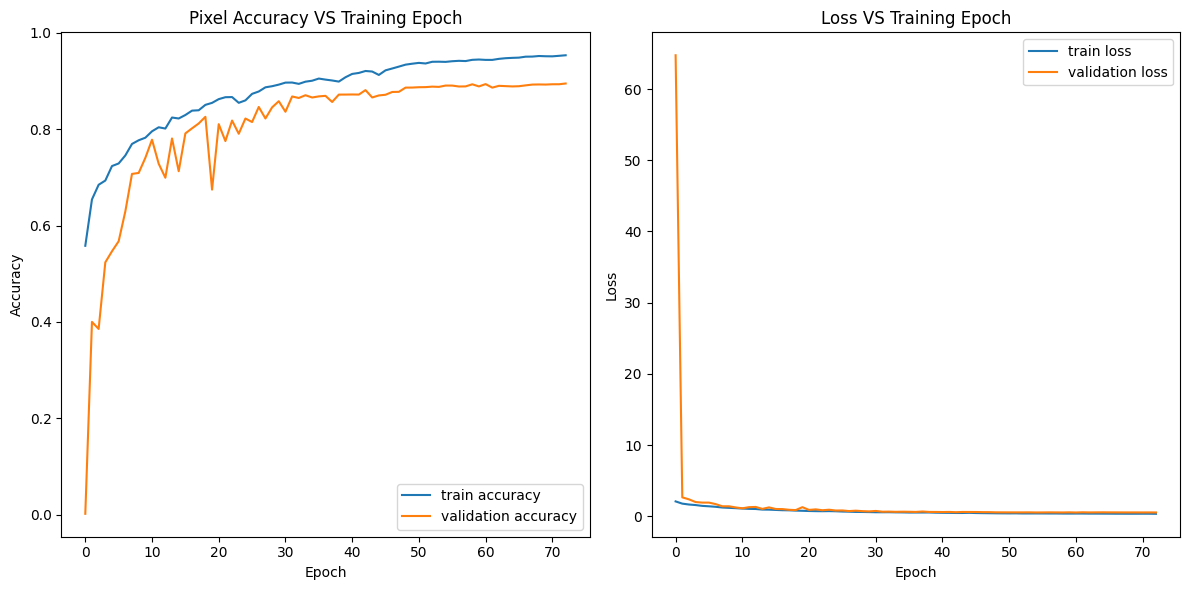

In [ ]:
# Plot learning curves
plot_learning_curves(model_history)

## Evaluation


### Evaluation Metrics
- IoU class by class
- Mean IoU
- Dice Coefficient
- Pixel accuracy

In [ ]:
'''
Make predictions for the test images and flatten them
'''
def predict_and_reshape(model, dataset):
  all_predictions = []
  all_labels = []
  for images, labels in tqdm(dataset):
    predictions = model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)  # predicted class --> shape (BATCH_SIZE, 128, 192)
    predictions = tf.reshape(predictions, [-1])  # flatten --> (BATCH_SIZE*IMG_HEIGHT*IMG_WIDTH, )
    labels = tf.reshape(labels, [-1])           # flatten --> (BATCH_SIZE*IMG_HEIGHT*IMG_WIDTH, )
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())
  return np.array(all_predictions), np.array(all_labels)


'''
Compute IoU
'''
def compute_iou(predictions, labels, num_classes=NUM_CLASSES):
  iou_list = []
  for class_id in range(num_classes):
    true_positive = np.sum((predictions == class_id) & (labels == class_id))
    false_positive = np.sum((predictions == class_id) & (labels != class_id))
    false_negative = np.sum((predictions != class_id) & (labels == class_id))
    union = true_positive + false_positive + false_negative

    if union == 0:
      iou = 1  # if there is no ground truth and no prediction for a certain class, IoU is 1
    else:
      iou = true_positive / union

    iou_list.append(iou)
  return iou_list


'''
Compute Accuracy
'''
def compute_accuracy(predictions, labels):

  accuracy_metric = tf.keras.metrics.Accuracy()
  accuracy_metric.update_state(labels, predictions)

  # Get the accuracy score
  accuracy = accuracy_metric.result().numpy()

  return accuracy


'''
Compute Dice Coefficient
'''
def compute_dice_coefficient(predictions, labels, num_classes=NUM_CLASSES):
  dice_scores = []
  eps = 1e-12     # to avoid division by 0
  for class_id in range(num_classes):
    pred_mask = (predictions == class_id)
    label_mask = (labels == class_id)

    intersection = np.sum(pred_mask & label_mask)
    dice_score = (2.0 * intersection) / (np.sum(pred_mask) + np.sum(label_mask) + eps)

    if np.sum(pred_mask) + np.sum(label_mask) == 0:
      dice_score = 1.0    # as before in the IoU

    dice_scores.append(dice_score)

  return dice_scores

In [ ]:
# Load your trained model
# unet = tf.keras.models.load_model('path/to/model')

# Make predictions on the test dataset
predictions, labels = predict_and_reshape(unet, test_batches)
# print(predictions.shape)    # num_test_batches*BATCH_SIZE*IMG_HEIGHT*IMG_WIDTH

# Compute IoU for each class
iou_scores = compute_iou(predictions, labels)

# Compute mean IoU
mean_iou = np.mean(iou_scores)

# Compute accuracy
acc = compute_accuracy(predictions, labels)

# Compute Dice for each class
dice_scores = compute_dice_coefficient(predictions, labels)

# Compute Mean Dice Coefficient
mean_dice = np.mean(dice_scores)

print("IoU for each class:", np.round(iou_scores,4))
print("Mean IoU:", np.round(mean_iou,4))
print("Pixel Accuracy: ", np.round(acc,4))

print("Class by class Dice Coefficient: ", np.round(dice_scores,4))
print("Mean Dice Coefficient: ", np.round(mean_dice,4))

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 1/3 [00:17<00:35, 17.73s/it]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 2/3 [00:27<00:13, 13.04s/it]

1/1 [==============================] - 10s 10s/step


100%|██████████| 3/3 [00:42<00:00, 14.10s/it]


(983040,)
IoU for each class: [0.     0.8931 0.5287 0.9357 0.7332 0.9286 0.3321 0.     0.6454 0.7038
 0.4875 0.5809 0.4216 0.365  0.0308 0.607  0.     0.6005 0.5759 0.5033
 0.6685 0.8148 0.4609]
Mean IoU: 0.5138
Pixel Accuracy:  0.8853
Class by class Dice Coefficient:  [0.     0.9435 0.6917 0.9668 0.846  0.963  0.4986 0.     0.7845 0.8262
 0.6555 0.7349 0.5931 0.5348 0.0597 0.7555 0.     0.7504 0.7309 0.6696
 0.8013 0.898  0.6309]
Mean Dice Coefficient:  0.6232


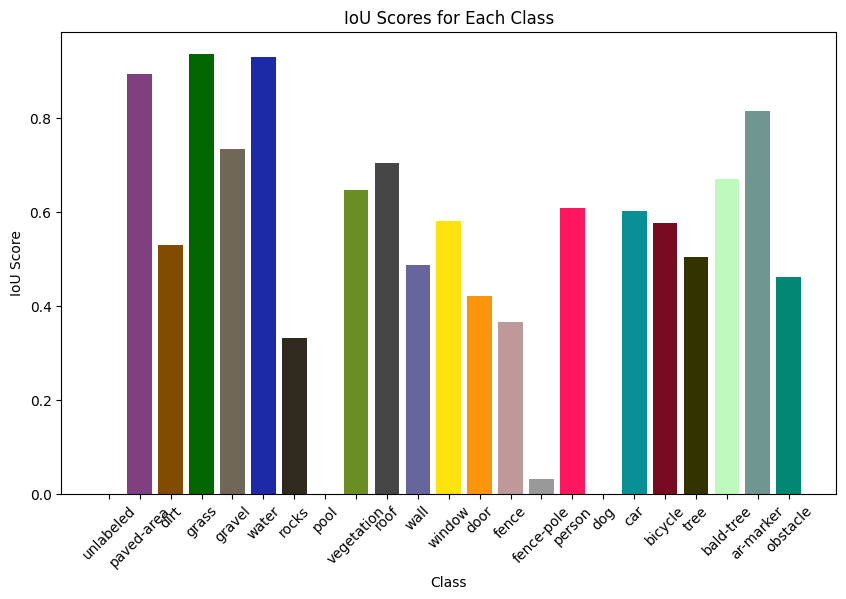

In [ ]:
# Barplot of the IoU per class
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_CLASSES), iou_scores, color=[color[0,0,:] for color in NORMALIZED_COLORS])
plt.xlabel('Class')
plt.ylabel('IoU Score')
plt.title('IoU Scores for Each Class')
plt.xticks(range(NUM_CLASSES), CLASSES_NAMES, rotation=45)
# plt.savefig("iou_dist_multiunet64_bs16")
plt.show()

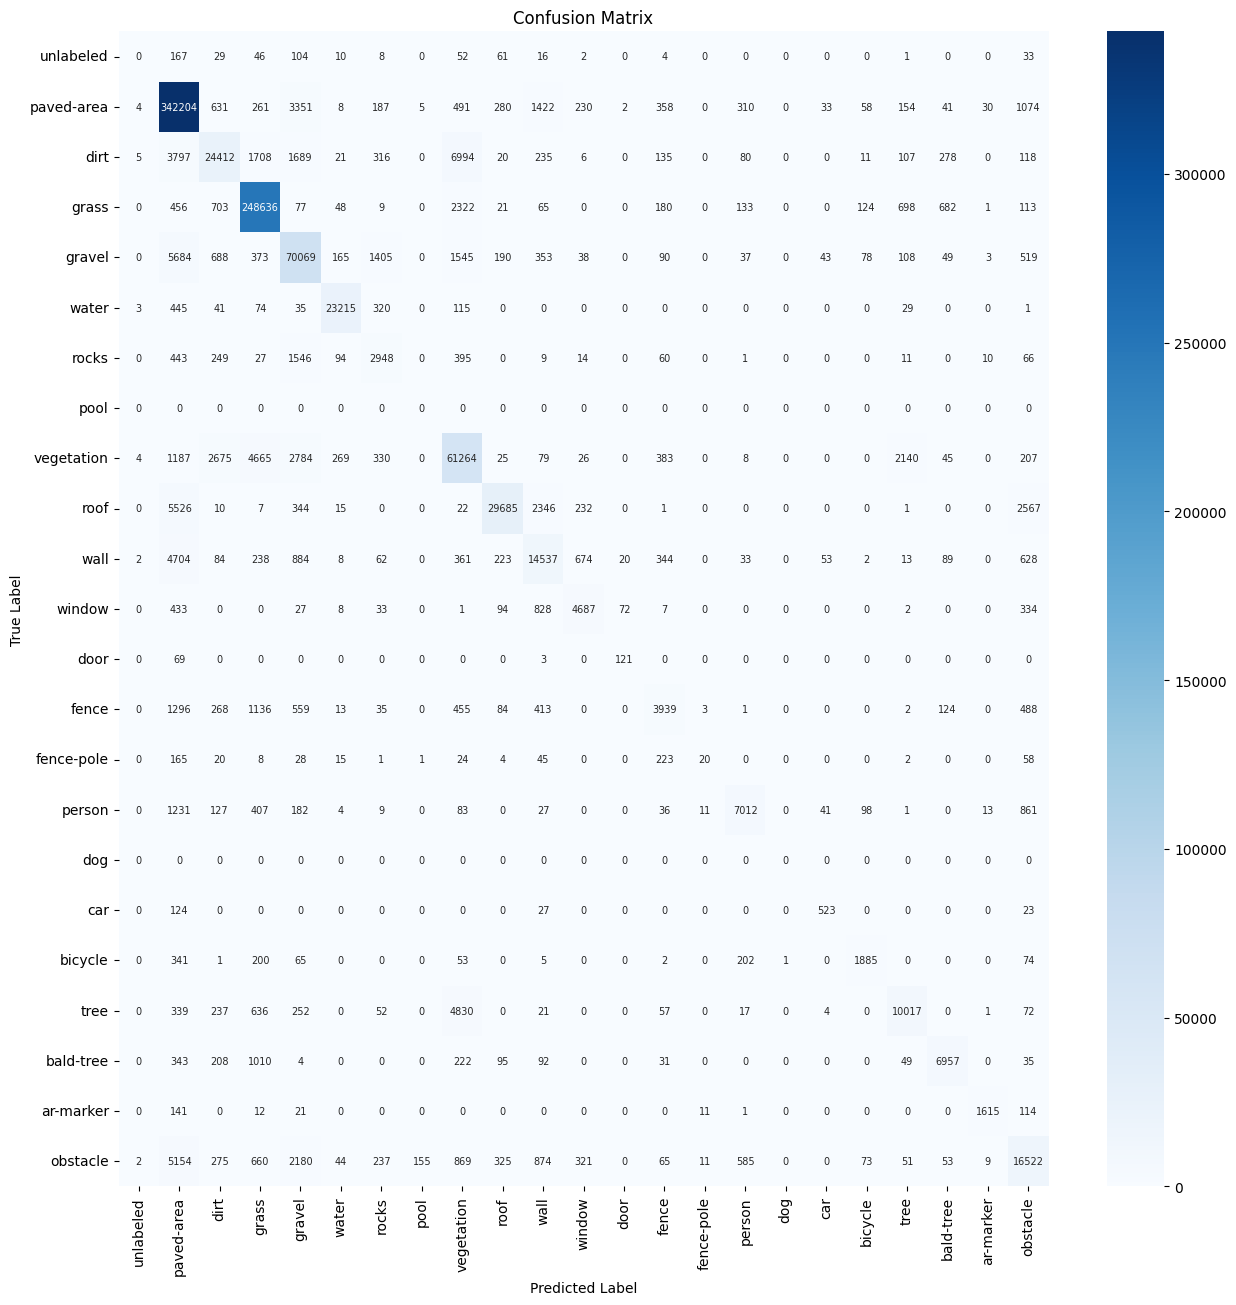

In [ ]:
def plot_confusion_matrix(predictions, labels, class_names):
  # Compute confusion matrix
  cm = confusion_matrix(labels, predictions, labels=range(len(class_names)))

  # Plot confusion matrix
  plt.figure(figsize=(15, 15))
  sns.heatmap(cm, annot=True, annot_kws={"size": 7}, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  # plt.savefig("conf_mat_multiunet64_bs16")
  plt.show()


plot_confusion_matrix(predictions, labels, CLASSES_NAMES)

### Test Time Augmentation (TTA)

In order to obtain a more robust prediction we use Test Time Augmentation.  
The key idea behind TTA is to apply various data augmentations to each test image and aggregate the predictions from these augmented versions to get a more accurate final prediction.  
In this case, to aggregate the predictions we chose a pixel-by-pixel **majority voting approach**: each pixel will be labeled with the label that has been chosen more times for that pixel by all the predictions.  

STEPS:
- for each test image apply augmentations
- pass the augmented images to the network to obtain predicted masks
- apply reverse augmentations to the masks
- aggregate predictions

In [ ]:
'''Apply tta transformations and return augmented images'''
def apply_tta(image):
  img1 = tf.image.flip_left_right(image)
  img2 = tf.image.flip_up_down(image)
  img3 = tf.image.rot90(image, k=1)  # tfa.image.rotate(image, np.pi/6)
  img4 = tf.image.rot90(image, k=3)  # tfa.image.rotate(image, np.pi/12)
  return (image, img1, img2, img3, img4)


'''Apply the inverse transformation to the predicted mask'''
def apply_inverse_tta(mask, i):
  if i==0:
    pass
  elif i==1:
    mask = tf.image.flip_left_right(mask)
  elif i==2:
    mask = tf.image.flip_up_down(mask)
  elif i==3:
    # mask = tfa.image.rotate(mask, -np.pi/6)
    mask = tf.image.rot90(mask, k=3)
  elif i==4:
    # mask = tfa.image.rotate(mask, -np.pi/12)
    mask = tf.image.rot90(mask, k=1)
  return mask


'''Make predictions for each test image, apply TTA, and return numpy flattened arrays'''
def predict_and_reshape_tta(model, dataset, num_classes=NUM_CLASSES):
  all_predictions = []
  all_labels = []

  for images, labels in dataset:
    # print("Shape: ", images.shape) # [16,128,192,3]
    tta_predictions = np.zeros((images.shape[0], images.shape[1], images.shape[2]))   # shape (BATCH_SIZE,IMG_HEIGHT,IMG_WIDTH)

    # Apply TTA
    for i in range(images.shape[0]):
      augmented_images = apply_tta(images[i])  #  5 images of shape (128,192,3)

      augmented_predictions = []
      for j,aug_img in enumerate(augmented_images):
        aug_img = tf.expand_dims(aug_img, axis=0)  # add batch dimension
        prediction = model.predict(aug_img)
        prediction = tf.argmax(prediction, axis=-1)  # predicted labels

        # Show output masks
        # plt.imshow(prediction.numpy().squeeze())
        # plt.show()
        # time.sleep(1)

        # Apply inverse TTA transform to the predicted mask
        prediction = tf.transpose(prediction, perm=[1, 2, 0]) # permute to [height, width, channels]

        prediction = apply_inverse_tta(prediction, j)     # shape (IMG_HEIGHT, IMG_WIDTH, 1)
        augmented_predictions.append(prediction)

      # Plot all predicted masks (retransformed) for the first 3 images
      if i<3:
        print("Predicted masks after inverse TTA transformations:")
        plot_predicted_masks(augmented_predictions)

      # Stack the 4 predicted masks
      stacked_predictions = np.stack(augmented_predictions, axis=0)         # shape (NUM_TTA_AUGM, IMG_HEIGHT, IMG_WIDTH, 1)
      stacked_predictions = np.squeeze(stacked_predictions, axis=-1)       # shape (NUM_TTA_AUGM, IMG_HEIGHT, IMG_WIDTH)

      # Calculate the mode along the first axis --> MAJORITY VOTING
      final_prediction = mode(stacked_predictions, axis=0)[0]    # shape (IMG_HEIGHT, IMG_WIDTH)

      tta_predictions[i] = final_prediction


    predictions = tf.reshape(tta_predictions, [-1])  # flatten tta predictions
    labels = tf.reshape(labels, [-1])  # flatten gt labels

    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())


    return np.array(all_predictions), np.array(all_labels)


'''Plot the predicted mask for each augmented image after applying the inverse transformation'''
def plot_predicted_masks(predicted_masks):
  num_augments = len(predicted_masks)

  fig, axes = plt.subplots(1, num_augments, figsize=(10,6))

  for i, mask in enumerate(predicted_masks):
    axes[i].imshow(colorize_mask(mask))
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 24ms/step
Predicted masks after inverse TTA transformations:


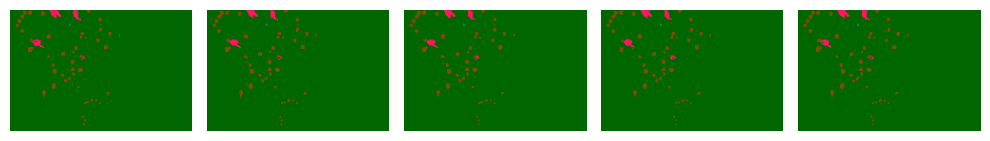

1/1 [==============================] - 0s 24ms/step
Predicted masks after inverse TTA transformations:


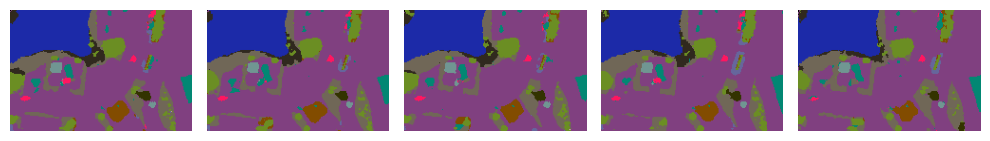

1/1 [==============================] - 0s 23ms/step
Predicted masks after inverse TTA transformations:


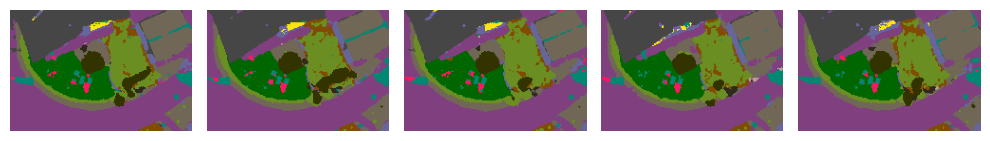

1/1 [==============================] - 0s 33ms/step
Predicted masks after inverse TTA transformations:


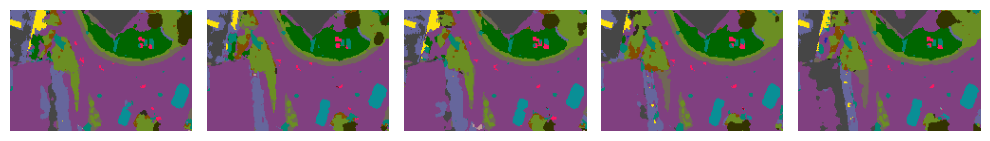

1/1 [==============================] - 0s 46ms/step
Predicted masks after inverse TTA transformations:


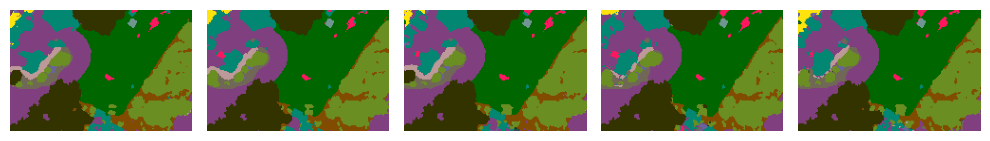

1/1 [==============================] - 0s 22ms/step
Predicted masks after inverse TTA transformations:


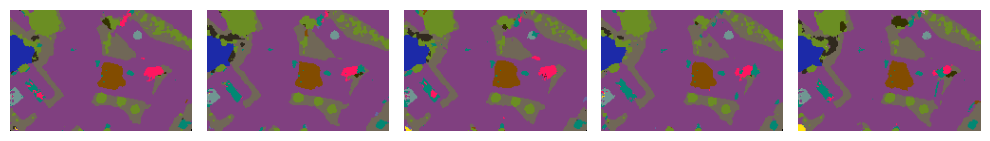

1/1 [==============================] - 0s 26ms/step
Predicted masks after inverse TTA transformations:


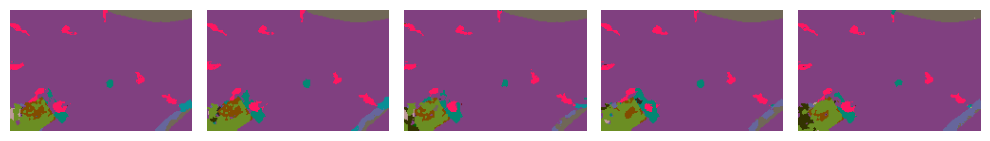

1/1 [==============================] - 0s 28ms/step
Predicted masks after inverse TTA transformations:


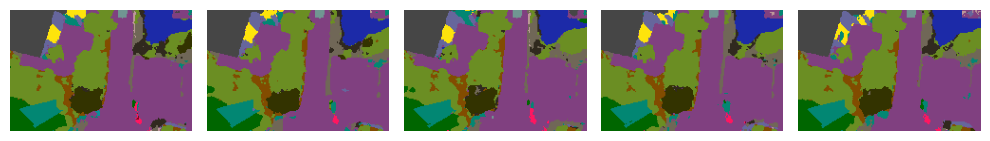

1/1 [==============================] - 0s 33ms/step
Predicted masks after inverse TTA transformations:


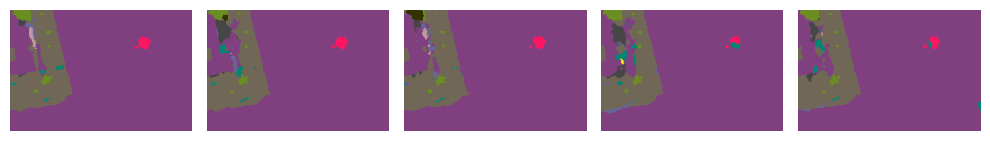

1/1 [==============================] - 0s 23ms/step
IoU for each class: [0.     0.888  0.5353 0.9377 0.7387 0.933  0.3635 0.     0.6603 0.6983
 0.5014 0.6043 0.5427 0.3413 0.0031 0.6205 1.     0.7528 0.5995 0.529
 0.6728 0.8089 0.4669]
Mean IoU: 0.5738
Pixel Accuracy:  0.888
Class by class Dice Coefficient:  [0.     0.9407 0.6973 0.9679 0.8497 0.9654 0.5331 0.     0.7954 0.8224
 0.6679 0.7533 0.7036 0.5089 0.0063 0.7658 1.     0.859  0.7496 0.692
 0.8044 0.8943 0.6366]
Mean Dice Coefficient:  0.6788


In [ ]:
# Get TTA predictions
tta_predictions, labels = predict_and_reshape_tta(unet, test_batches)

# Compute IoU for each class
iou_scores_tta = compute_iou(tta_predictions, labels)

# Compute mean IoU
mean_iou_tta = np.mean(iou_scores_tta)

# Compute accuracy
acc_tta = compute_accuracy(tta_predictions, labels)

# Compute Dice for each class
dice_scores_tta = compute_dice_coefficient(tta_predictions, labels)

# Compute Mean Dice Coefficient
mean_dice_tta = np.mean(dice_scores_tta)

print("IoU for each class:", np.round(iou_scores_tta,4))
print("Mean IoU:", np.round(mean_iou_tta,4))
print("Pixel Accuracy: ", np.round(acc_tta,4))

print("Class by class Dice Coefficient: ", np.round(dice_scores_tta,4))
print("Mean Dice Coefficient: ", np.round(mean_dice_tta,4))

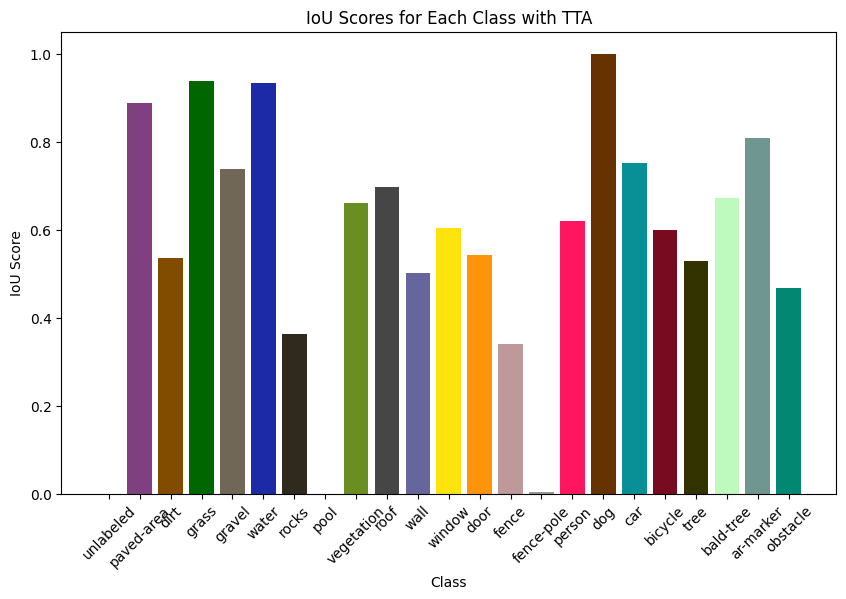

In [ ]:
# Barplot of the IoU per class
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_CLASSES), iou_scores_tta, color=[color[0,0,:] for color in NORMALIZED_COLORS])
plt.xlabel('Class')
plt.ylabel('IoU Score')
plt.title('IoU Scores for Each Class with TTA')
plt.xticks(range(NUM_CLASSES), CLASSES_NAMES, rotation=45)
# plt.savefig("iou_dist_TTA_multiunet64_bs16")
plt.show()

### Visual Evaluation

In [ ]:
'''Create mask in the right shape'''
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)  # shape (IMG_HEIGHT, IMG_WIDTH)
  pred_mask = pred_mask[..., tf.newaxis]    # shape (IMG_HEIGHT, IMG_WIDTH, 1)
  return pred_mask


'''Plot predictions using the display function'''
def show_predictions(model, dataset, num=1):
  if num % BATCH_SIZE == 0:
    n_batches = num//BATCH_SIZE
  else:
    n_batches = num//BATCH_SIZE + 1
  for image, mask in dataset.take(n_batches):
    pred_mask = model.predict(image)
    for i in range(num//n_batches):
      display([image[i], mask[i], create_mask(pred_mask[i])])


'''Plot prediction made with TTA'''
def show_predictions_tta(gt, preds, num=3):
  plt.figure(figsize=(10, 2 * num))

  for i in range(num):
    # Plot ground truth
    plt.subplot(num, 2, 2 * i + 1)
    plt.imshow(colorize_mask(gt[i]))
    plt.title(f'True Mask')
    plt.axis('off')

    # Plot prediction
    plt.subplot(num, 2, 2 * i + 2)
    plt.imshow(colorize_mask(preds[i]))
    plt.title(f'TTA Prediction')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
NUM_BATCHES = 0
for i in test_batches:
  NUM_BATCHES +=1
print("number of batches:", NUM_BATCHES)

number of batches: 3


1/1 [==============================] - 0s 28ms/step


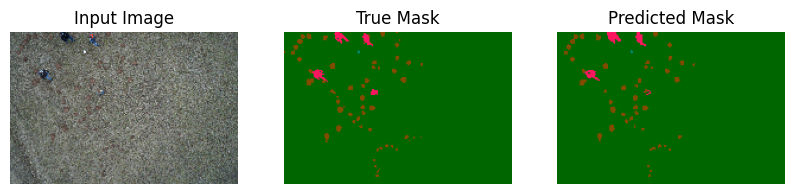

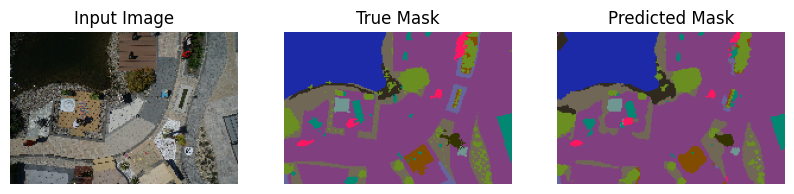

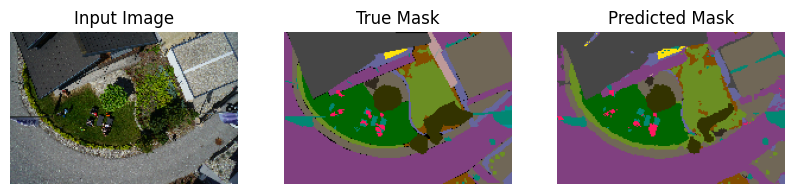

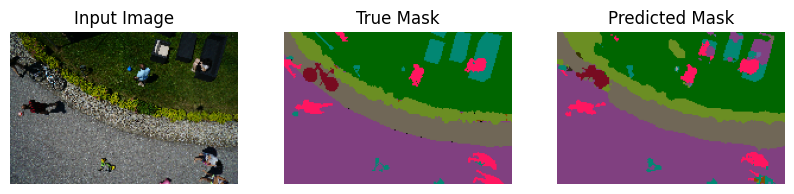

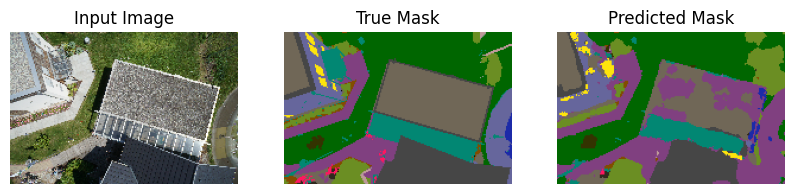

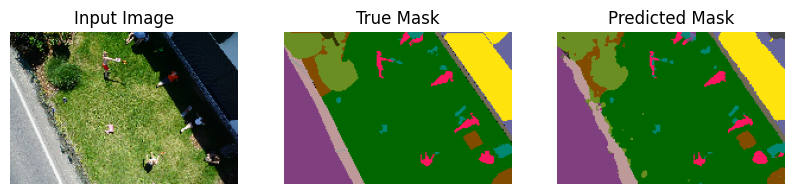

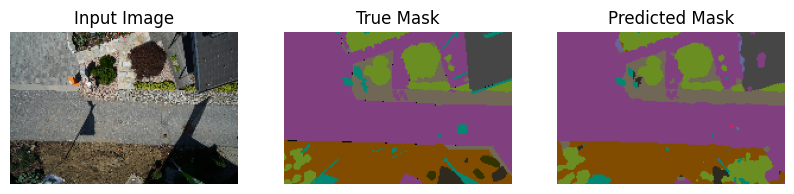

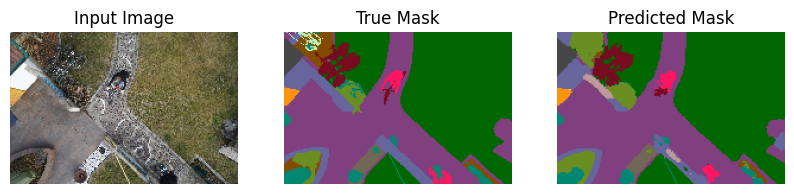

In [ ]:
# Show predicted masks
show_predictions(unet, test_batches, 8)

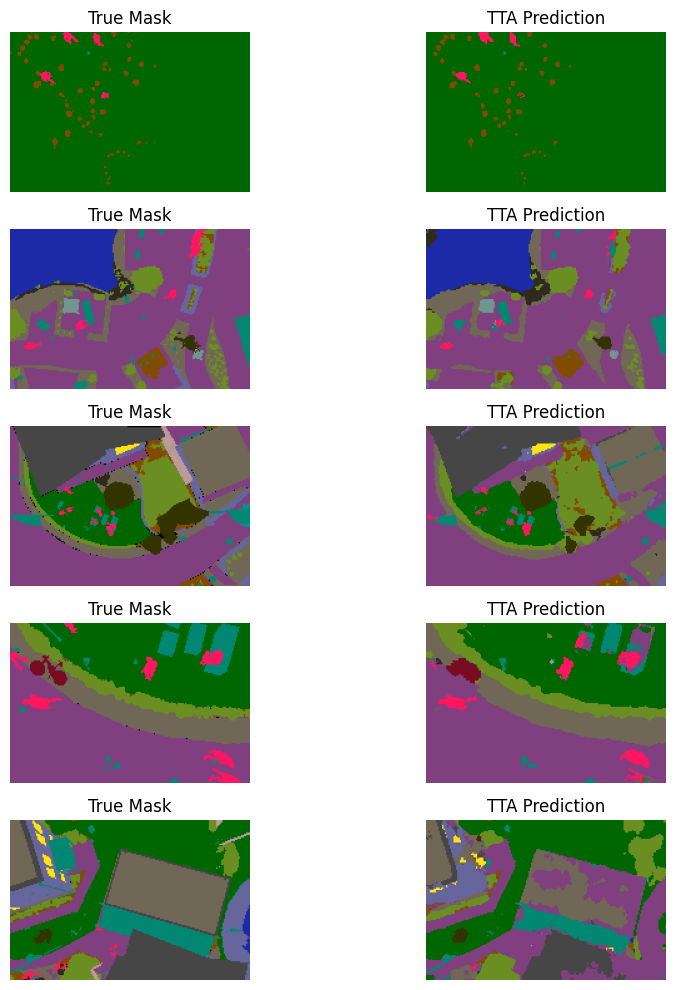

In [ ]:
# Show TTA predictions
tta_preds_reshaped = tta_predictions.reshape(len(test_dataset), IMG_HEIGHT, IMG_WIDTH)
gt_labels_reshaped = labels.reshape(len(test_dataset), IMG_HEIGHT, IMG_WIDTH)

show_predictions_tta(gt_labels_reshaped, tta_preds_reshaped, num=5)

## Land the drone!

We want to find the position that maximizes the distance to all the "risky" classes, aiming for the safest landing of the drone.

In [ ]:
# Select all classes but grass, paved-area, and gravel
TARGET_CLASSES = [0, 2, 5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 16, 17, 18, 19, 20,21,22 ]

In [ ]:
def find_landing_position(predicted_mask, target_classes=TARGET_CLASSES):
  # Convert the predicted mask into a class mask
  class_mask = tf.argmax(predicted_mask, axis=-1).numpy()

  # Initialize an array to save the combined distance map
  combined_distance_map = np.full(class_mask.shape, np.inf)

  # Create distance maps for each target class and combine them
  for target_class in target_classes:
    # Create a binary mask for the current class
    binary_mask = (class_mask == target_class).astype(np.uint8)

    # Compute the distance transform (euclidean)
    distance_map = cv2.distanceTransform(1 - binary_mask, cv2.DIST_L2, 3)

    # Combine the distance maps by taking the element-wise minimum
    combined_distance_map = np.minimum(combined_distance_map, distance_map)

  # Compute the distance from the borders of the image
  height, width = class_mask.shape
  border_distance_map = np.minimum.reduce([
      np.indices((height, width))[0],          # distance from top
      np.indices((height, width))[1],          # distance from left
      height - np.indices((height, width))[0], # distance from bottom
      width - np.indices((height, width))[1]   # distance from right
  ])

  # Combine target classes distance map with the border distance map
  total_distance_map = np.minimum(combined_distance_map, border_distance_map)

  # Find the position with the maximum distance in the total distance map
  max_distance_pos = np.unravel_index(np.argmax(total_distance_map), total_distance_map.shape)

  return max_distance_pos


'''Plot predicted mask with landing position'''
def show_landing_positions(model, dataset, num=1):
  if num % BATCH_SIZE == 0:
    n_batches = num//BATCH_SIZE
  else:
    n_batches = num//BATCH_SIZE + 1
  for image, mask in dataset.take(n_batches):
    pred_mask = model.predict(image)
    for i in range(num//n_batches):
      landing_pos = find_landing_position(pred_mask[i])
      display([image[i], mask[i], create_mask(pred_mask[i])], landing_pos)



1/1 [==============================] - 0s 25ms/step


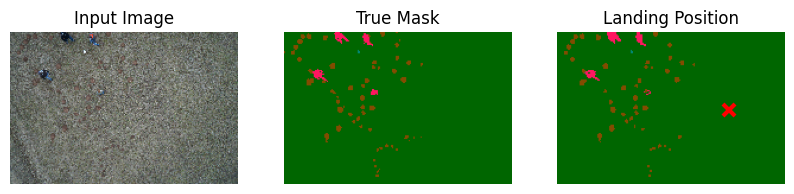

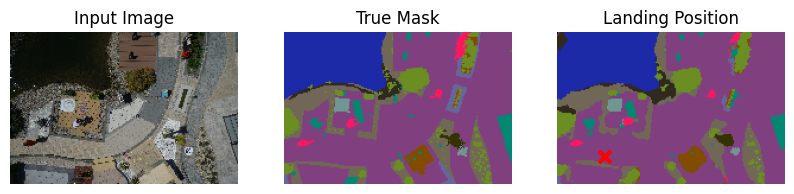

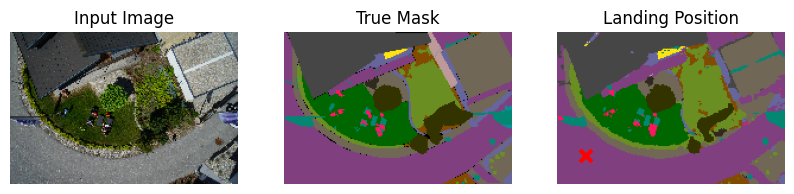

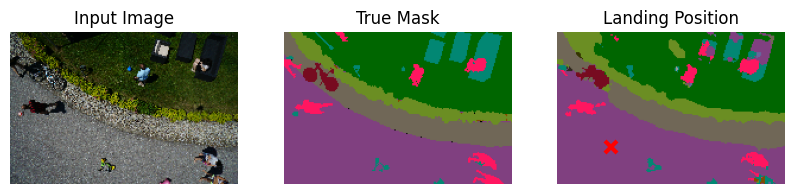

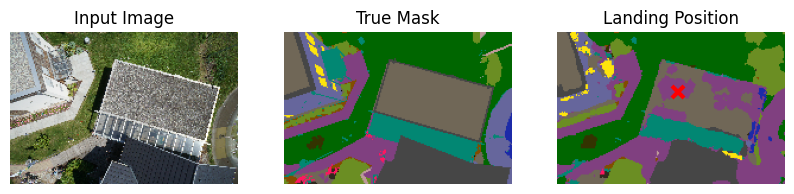

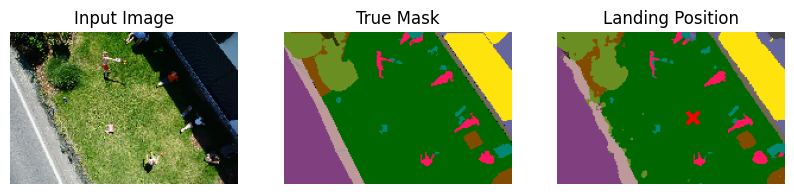

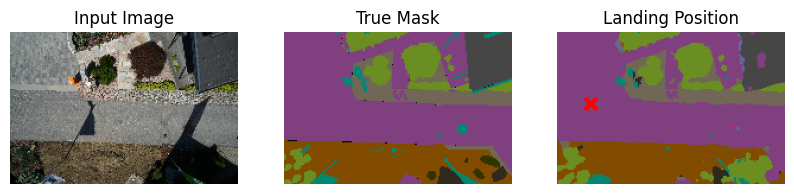

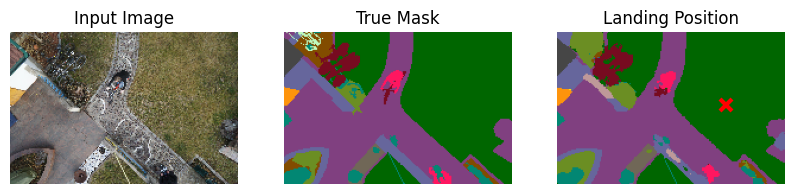

In [ ]:
# Plot some test images with predicted mask and landing position
show_landing_positions(unet, test_batches, 8)

## Connected Component Analysis

CCA can be useful to count how many people (or objects of another class) there are in an image and where they are located. This could be useful for example for providing aid during emergencies.

In [ ]:
from scipy.ndimage import label, find_objects

'''Find connected components of the specified class_id in the input mask'''
def apply_cca(mask, class_id):
  mask_np = mask.numpy().squeeze()
  binary_mask = (mask_np == class_id).astype(np.int32)
  # Apply CCA
  labeled_array, num_features = label(binary_mask)
  # object_slices = find_objects(labeled_array)
  return mask_np, labeled_array


'''Plot CCA masks'''
def show_cca(model, dataset, num=1, class_id=15):
  if num % BATCH_SIZE == 0:
    n_batches = num//BATCH_SIZE
  else:
    n_batches = num//BATCH_SIZE + 1
  for images, masks in dataset.take(n_batches):
    pred_masks = model.predict(images)
    for i in range(num//n_batches):
      gt_mask, gt_cca = apply_cca(masks[i], class_id=class_id)
      pred_mask, pred_cca = apply_cca(create_mask(pred_masks[i]), class_id)

      plt.figure(figsize=(10, 5))

      # GT mask
      plt.subplot(2, 2, 1)
      plt.title("GT Mask")
      plt.imshow(colorize_mask(gt_mask))
      plt.axis('off')

      # Labeled GT mask
      plt.subplot(2, 2, 2)
      plt.title(f"Objects for Class '{CLASSES_NAMES[class_id]}'")
      plt.imshow(colorize_mask(gt_cca))
      plt.axis('off')

      # Predicted mask
      plt.subplot(2, 2, 3)
      plt.title("Predicted Mask")
      plt.imshow(colorize_mask(pred_mask))
      plt.axis('off')

      # Labeled pred mask
      plt.subplot(2, 2, 4)
      plt.title(f"Objects for Class '{CLASSES_NAMES[class_id]}'")
      plt.imshow(colorize_mask(pred_cca))
      plt.axis('off')

      plt.show()


In [ ]:
# Show connected components for class 'person' in both GT masks and predicted masks
show_cca(unet, test_batches, 5)